In [1]:
#Manual cutflow on search for LLPs decaying in muon spectrometer

In [1]:
#Import libraries
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import time
import math

#Load signal file
sig_file = uproot.open("user.calpert.mc16_13TeV.311423.MGPy8EG_A14NNPDF23_NNPDF31ME_HSS_LLP_mH600_mS150_lthigh.032123_trees.root/user.calpert.311423.e7357_e5984_s3234_r10201_r10210_p4696.32829947._000001.trees.root:trees_DV_")

In [2]:
#Define helper functions. These functions display relevant info about a branch if needed.
def dp(branch, length):
    if length > len(branch):
        length = len(branch)  # Ensures we do not go out of range if length is greater than the branch size
    for i, value in enumerate(branch[:length]):
        print("Value:", value, "   Index:", i)

def ratio(branch):
    ratio = ak.count_nonzero(branch)/ak.count(branch)
    print(ratio) #Display ratio of number of elements that pass

## Pass Qual

In [3]:
goodPV = sig_file["hasGoodPV"].array()

In [4]:
cut1 = goodPV == True

In [5]:
ratio(cut1)

1.0


## Pass Trigger

In [6]:
trig = sig_file["pass_HLT_j30_muvtx_noiso"].array()

In [7]:
cut2 = cut1 & trig == True

In [8]:
ratio(cut2)

0.23718


## With 2 Vertices

In [9]:
#Keep verticies with a multiplicity of at least 2
#Use any MsVtx branch but eta will do.
eta = sig_file["MSVtx_eta"].array()
multiplicity = ak.num(eta) >=2  #COUNT AFTER GOOD VERTICES


In [10]:
cut3 = cut2 & multiplicity == True

In [11]:
ratio(cut3)

0.01338


## With Two Good Vertices

In [12]:
eta = sig_file["MSVtx_eta"].array()
mdt = sig_file["MSVtx_nMDT"].array()
rpc = sig_file["MSVtx_nRPC"].array()
tgc = sig_file["MSVtx_nTGC"].array()
ntrks = sig_file['MSVtx_nTrks'].array()

In [13]:
#CUT FOR MDT AND RPC HITS IN BARREL
mdt_hits = (mdt >= 300) & (mdt < 3000)
rpc_hits = ((rpc > 250) & (abs(eta) <= 1.0)) | ((abs(eta) > 1.0) & (rpc == True))
tgc_hits = ((tgc > 250) & ((abs(eta) > 1) & (abs(eta) < 2.5))) | ((((abs(eta) <= 1.0) | (abs(eta) >= 2.5)) & (tgc == True)))

#Will need to check # of tracks per vertex. Make sure there are 3(4) in barrel(endcap)
ntrks_barrel = ntrks >=3
ntrks_endcap = ntrks >=4

#CUT FOR VETO REGION
veto_cut = (0.7 < eta) & (1.3 > eta)

hits_barrel_cut= mdt_hits & rpc_hits & ntrks_barrel 
hits_endcap_cut = mdt_hits & tgc_hits & ntrks_endcap


#Discard erroneous values
#MS_good_trks = ntrks[ntrks > 0]  #LABEL MS GOOD TRACKS



In [14]:
hits_cut = (hits_barrel_cut) | hits_endcap_cut

In [15]:
final_hits_cut = hits_cut & veto_cut

In [16]:
cut4 = final_hits_cut & cut3

In [17]:
ratio(cut4)

0.003995064919804947


In [18]:
ak.count_nonzero(cut4)

204

## 2 good vtx w/ Iso cuts

### 3 Criteria: Jet isolation, track isolation and sum pT cut

In [19]:
#Calculate jet cutflow first
#Load necessary branches
jet_pT=sig_file['jet_pT'].array()
jet_logRatio=sig_file['jet_logRatio'].array() 
jet_JVT=sig_file['jet_jvt'].array() 
jet_eta=sig_file['jet_eta'].array() 
jet_phi=sig_file['jet_phi'].array() 
track_pT = sig_file['track_pT'].array()
track_eta = sig_file['track_eta'].array()
track_phi = sig_file['track_phi'].array()
MS_eta = sig_file["MSVtx_eta"].array()
MS_phi = sig_file["MSVtx_phi"].array()
sum_pT = sig_file['MSVtx_sumTrackPt0p2Cone'].array()

In [20]:
#Reduce to event level for eliminating vertices due to iso cuts. Produces 1-d array showing # of good vertices per event
good_vtx = ak.count_nonzero(cut4, axis=1)

In [21]:
ratio(cut4)

0.003995064919804947


In [22]:
#First perform cutflow on jets. 
#logRatio < 0.5 rejects vertices near end of calorimeters
#jetpT and jetJVT requirements prevent pileup/underlying event spoiling a true vertex
jet_cut = (jet_logRatio < 0.5) & (jet_pT > 30) & (((jet_JVT > 0.59) & (jet_pT < 60)) | ((jet_pT > 60)))
#produce a 1-d array with number of jets passing cut per event
jet_count = ak.count_nonzero(jet_cut, axis=1)

In [23]:
ratio(jet_cut)

0.13895957389081667


In [24]:
#Jet Isolation
#Create cross products of jet_eta, MS_Vtx_eta, jet_phi,and MS_Vtx_phi
jet_etaPairs = ak.cartesian({"x":jet_eta, "y":MS_eta}, axis=1) 
jet_phiPairs = ak.cartesian({"x":jet_phi, "y":MS_phi}, axis=1) 

In [25]:
delta_jet_eta = abs(jet_etaPairs["x"] - jet_etaPairs["y"])
delta_jet_phi = abs(jet_phiPairs["x"] - jet_phiPairs["y"])

In [26]:
delta_jet = (delta_jet_eta * delta_jet_eta) + (delta_jet_phi * delta_jet_phi)

In [27]:
#Place cut on delta threshold for barrel and endcap
delta_cut_barrel = delta_jet<0.09
delta_cut_endcap = delta_jet<0.36

In [28]:
delta_count_barrel = ak.count_nonzero(delta_cut_barrel, axis=1)
delta_count_endcap = ak.count_nonzero(delta_cut_endcap, axis=1)

In [29]:
#Using good_vtx, jet_count and delta_count....figure how many vertices to cut in barrel
jet_iso_vtx_barrel = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if ((delta_count_barrel[i] > jet_count[i])) | (((delta_count_barrel[i] == jet_count[i]) & (jet_count[i] > 0))):
        jet_iso_vtx_barrel[i] = good_vtx[i] - jet_count[i]
    elif (delta_count_barrel[i] <= jet_count[i]):
        jet_iso_vtx_barrel[i] = (good_vtx[i] - delta_count_barrel[i])

In [30]:
#Using good_vtx, jet_count and delta_count....figure how many vertices to cut in endcap
jet_iso_vtx_endcap = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if ((delta_count_endcap[i] > jet_count[i])) | (((delta_count_endcap[i] == jet_count[i]) & (jet_count[i] > 0))):
        jet_iso_vtx_endcap[i] = good_vtx[i] - jet_count[i]
    elif (delta_count_endcap[i] <= jet_count[i]):
        jet_iso_vtx_endcap[i] = (good_vtx[i] - delta_count_endcap[i])

In [31]:
good_vtx_np = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if good_vtx[i] <0:
        good_vtx_np[i] = 0
good_vtx = ak.from_numpy(good_vtx_np)

In [32]:
ak.count_nonzero(good_vtx)

97

#### Track Isolation

In [33]:
track_etaPairs = ak.cartesian({"x":track_eta, "y":MS_eta}, axis=1) 
track_phiPairs = ak.cartesian({"x":track_phi, "y":MS_phi}, axis=1) 

In [34]:
delta_track_eta = abs(track_etaPairs["x"] - track_etaPairs["y"])
delta_track_phi = abs(track_phiPairs["x"] - track_phiPairs["y"])

In [35]:
delta_track = (delta_track_eta * delta_track_eta) + (delta_track_phi * delta_track_phi)

In [36]:
delta_cut_barrel = (delta_track<0.09)
delta_cut_endcap = (delta_track<0.36)

In [37]:
delta_count_barrel = ak.count_nonzero(delta_cut_barrel, axis=1)
delta_count_endcap = ak.count_nonzero(delta_cut_endcap, axis=1)
track_pt_count = ak.any(track_pT > 17, axis =1)

In [38]:
track_iso_vtx_barrel = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if ((delta_count_barrel[i] > jet_count[i])) & (track_pt_count[i] == True) | ((delta_count_barrel[i] == jet_count[i]) & (jet_count[i] > 0) & (track_pt_count[i] == True)):
        track_iso_vtx_barrel[i] = good_vtx[i] - jet_count[i]
    elif (delta_count_barrel[i] <= jet_count[i]):
        track_iso_vtx_barrel[i] = (good_vtx[i] - delta_count_barrel[i])

In [39]:
track_iso_vtx_endcap = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if ((delta_count_endcap[i] > jet_count[i]) | ((delta_count_endcap[i] == jet_count[i]) & (jet_count[i] > 0))) & (track_pt_count[i] == True):
        track_iso_vtx_endcap[i] = good_vtx[i] - jet_count[i]
    elif (delta_count_endcap[i] <= jet_count[i]) & (track_pt_count[i] == True):
        track_iso_vtx_endcap[i] = (good_vtx[i] - delta_count_endcap[i])

In [40]:
good_vtx_np = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if good_vtx[i] <0:
        good_vtx_np[i] = 0
good_vtx = ak.from_numpy(good_vtx_np)

In [41]:
ak.count_nonzero(good_vtx)

63

In [42]:
sum_pt_cut = sum_pT > 10
pt_iso = ak.count_nonzero(sum_pt_cut, axis=1)

In [43]:
pt_np = ak.to_numpy(good_vtx)
for i, value in enumerate(good_vtx):
    if (pt_iso[i] > 0):
        pt_np[i] = pt_np[i] - pt_iso[i]
for i, value in enumerate(pt_np):
    if pt_np[i] < 0:
        pt_np[i] = 0
final_cut = ak.from_numpy(pt_np)

In [44]:
ak.count_nonzero(final_cut)

50

## Plot cutflow chart

In [45]:
r0 = ratio(goodPV)
r1 = ratio(cut1)
r2 = ratio(cut2)
r3 = ratio(cut3)
r4 = ratio(cut4)
r5 = ratio(final_cut)

x1 = 1
x2 = (ak.count_nonzero(cut1)/ak.count_nonzero(goodPV))
x3 = (ak.count_nonzero(cut2)/ak.count_nonzero(cut1))
x4 = (ak.count_nonzero(cut3)/ak.count_nonzero(cut2))
x5 = (ak.count_nonzero(cut4)/ak.count_nonzero(cut3))
x6 = (ak.count_nonzero(final_cut)/ak.count_nonzero(cut4))

1.0
1.0
0.23718
0.01338
0.003995064919804947
0.001


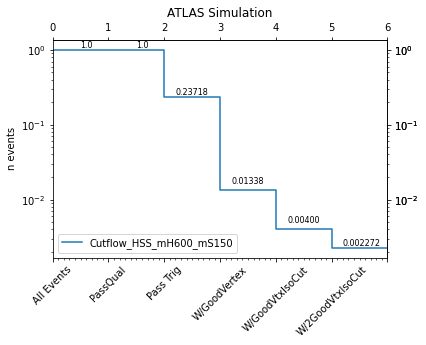

In [49]:
x = [0,1,2,3,4,5,6]
y = [1.0,1.0, 1.0, .23718, .01338,.00400,.002272]
fig, ax = plt.subplots()
plt.step(x, y)

ax.set_ylabel('n events')

plt.xlim(0,6)
my_xticks = ['All Events','PassQual','Pass Trig','W/GoodVertex', 'W/GoodVtxIsoCut','W/2GoodVtxIsoCut','']

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, 6, 1)
minor_ticks = np.arange(0, 6, .1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

plt.xticks(x, my_xticks, rotation=45)
plt.tick_params(labeltop=False, direction="out", labelright=True)

ax2 = ax.secondary_yaxis("right")
ax2.tick_params(axis="y", direction="out")

ax3 = ax.secondary_xaxis("top", label=False)
ax3.tick_params(axis="x")

plt.text(.5,1.05, '1.0', fontsize = 8)
plt.text(1.5,1.05, '1.0', fontsize = 8)
plt.text(2.2,.25, '0.23718', fontsize = 8)
plt.text(3.2,.016, '0.01338', fontsize = 8)
plt.text(4.2,0.0048, '0.00400', fontsize = 8)
plt.text(5.2,0.0024, '0.002272', fontsize = 8)

ax.set_title('ATLAS Simulation')
plt.legend(['Cutflow_HSS_mH600_mS150'], loc="lower left")

plt.yscale("log")
plt.show()